# Tarea Principal
- Se pide implementar el método de *Co-Training* propuesto Blum y Mitchell en $1998$ en Python. Después utilizarlo para aplicarlo en un conjunto de datos de aprendizaje semi-supervisado.

## Problema
- El aprendizaje semi-supervisado es un tipo de aprendizaje que combina el aprendizaje supervisado con el aprendizaje supervisado. En este se tienen una serie de datos etiquetados (no muchos) y una gran mayoría de datos no etiquetados. También puede darse el caso contrario en el que hay muchos datos etiquetados y unos pocos no etiquetados.
- La idea principal es tratar de mejorar la información que aportan los datos no etiquetados para enriquecer los datos etiquetados, aprovechando ambos tipos de información para mejorar el aprendizaje.

## Solución de *Co-Training* por Blum y Mitchell
- En el método *Co-Training* cada ejemplo $x$ se representa como un par ($x_1, x_2$), donde $x_1\in X_1$ y $x_2\in X_2$. Estos dos conjuntos son vistas distintas del mismo ejemplo. 
- Se define la distribución subyacente $D$, donde se asigna una probabilidad cero a cada ejemplo donde las vistas son inconsistentes, es decir, $D(x_1,x_2)=0$ si $f_1(x_1)\neq f_2(x_2)$, donde cada una de estas funciones corresponden a las funciones objetivo de cada vista.
- Una función objetivo $f=(f_1,f_2)$ es compatible con $D$ si $D$ asigna probabilidad cero para aquellos pares cuyas imágenes no sean iguales. De esta forma solo se consideran funciones consistentes entre ambas vistas.
- Dada esta pequeña introducción de las estructuras de datos utilizadas y de algunos conceptos teóricos, el algoritmo *Co-Training* trata de entrenar dos modelos ($h_1, h_2$) en los dos conjuntos de datos definidos $X_1,X_2$, con un conjunto pequeño de datos etiquetados $L$. 
- Cada modelo aprendido trata de etiquetar con alta confianza los ejemplos $U$ no etiquetados, solo aquellos que superen un umbral de confianza.
- Estos ejemplos seleccionados se añaden a $L$ y se entrena con las etiquetas predichas por el modelo. De esta forma se repite hasta alcanzar un número de iteraciones, convergencia u otro criterio de parada.

# Implementación en Python

In [1]:
from sklearn.base import clone, BaseEstimator
from sklearn.utils.validation import check_X_y
import numpy as np
import random


class CoTrainingClassifier(BaseEstimator):
    def __init__(self, model=None, p=1, n=1, u=75, max_iter=30):
        self.estimator1 = clone(model)
        self.estimator2 = clone(model)
        self.p = p  # Positive examples to add per view per iteration
        self.n = n  # Negative examples to add per view per iteration
        self.u = u  # Unlabeled pool size
        self.max_iter = max_iter
        self.classes_ = None

    def _split_views(self, X):
        n_features = X.shape[1]
        indices = list(range(n_features))
        random.shuffle(indices)
        mid = n_features // 2
        self.view1_indices_ = indices[:mid]
        self.view2_indices_ = indices[mid:]
        return X[:, self.view1_indices_], X[:, self.view2_indices_]

    def _get_confident_examples(self, estimator, X, p, n):
        if X.shape[0] == 0:
            return {"positive": [], "negative": []}

        probs = estimator.predict_proba(X)
        pos_probs = probs[:, 1]  # Class 1 probabilities
        neg_probs = probs[:, 0]  # Class 0 probabilities

        # Get indices sorted by confidence (descending)
        pos_indices = np.argsort(-pos_probs)[: min(p, X.shape[0])]
        neg_indices = np.argsort(-neg_probs)[: min(n, X.shape[0])]

        return {"positive": pos_indices, "negative": neg_indices}

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y[y != -1])

        # Split features into two views
        X1, X2 = self._split_views(X)

        # Identify labeled and unlabeled examples
        labeled_mask = y != -1
        unlabeled_mask = ~labeled_mask

        # Initially labeled examples
        X1_labeled = X1[labeled_mask]
        X2_labeled = X2[labeled_mask]
        y_labeled = y[labeled_mask]

        # Keep track of which examples are still unlabeled
        remaining_unlabeled = np.where(unlabeled_mask)[0]

        # Create initial unlabeled pool
        if len(remaining_unlabeled) > self.u:
            pool_indices = np.random.choice(remaining_unlabeled, self.u, replace=False)
        else:
            pool_indices = remaining_unlabeled.copy()

        # Main co-training loop
        for _ in range(self.max_iter):
            if len(pool_indices) == 0:
                break

            # Train both models on current labeled data
            self.estimator1.fit(X1_labeled, y_labeled)
            self.estimator2.fit(X2_labeled, y_labeled)

            # Get unlabeled pool data for both views
            U1 = X1[pool_indices]
            U2 = X2[pool_indices]

            # Get confident examples from each view
            ex1 = self._get_confident_examples(self.estimator1, U1, self.p, self.n)
            ex2 = self._get_confident_examples(self.estimator2, U2, self.p, self.n)

            # Track which examples to move from unlabeled to labeled
            to_label_pool_indices = []
            new_X1, new_X2, new_y = [], [], []

            # Process view1's confident predictions
            for cls_type, cls_val in [("positive", 1), ("negative", 0)]:
                for idx in ex1.get(cls_type, []):
                    pool_idx = pool_indices[idx]
                    if pool_idx not in to_label_pool_indices:  # Avoid duplicates
                        to_label_pool_indices.append(pool_idx)
                        new_X1.append(X1[pool_idx])
                        new_X2.append(X2[pool_idx])
                        new_y.append(cls_val)

            # Process view2's confident predictions
            for cls_type, cls_val in [("positive", 1), ("negative", 0)]:
                for idx in ex2.get(cls_type, []):
                    pool_idx = pool_indices[idx]
                    if pool_idx not in to_label_pool_indices:  # Avoid duplicates
                        to_label_pool_indices.append(pool_idx)
                        new_X1.append(X1[pool_idx])
                        new_X2.append(X2[pool_idx])
                        new_y.append(cls_val)

            # If we found new examples to label
            if new_X1:
                # Add to labeled sets
                X1_labeled = np.vstack([X1_labeled, new_X1])
                X2_labeled = np.vstack([X2_labeled, new_X2])
                y_labeled = np.append(y_labeled, new_y)

                # Remove labeled examples from pool
                pool_indices = np.array(
                    [idx for idx in pool_indices if idx not in to_label_pool_indices]
                )

                # Update remaining unlabeled set by removing labeled examples
                remaining_unlabeled = np.array(
                    [
                        idx
                        for idx in remaining_unlabeled
                        if idx not in to_label_pool_indices
                    ]
                )

                # Replenish pool if possible
                num_to_add = min(len(to_label_pool_indices), len(remaining_unlabeled))
                if num_to_add > 0:
                    choices = np.random.choice(
                        len(remaining_unlabeled), num_to_add, replace=False
                    )
                    new_pool_examples = remaining_unlabeled[choices]
                    pool_indices = np.append(pool_indices, new_pool_examples)
                    # Remove chosen examples from remaining_unlabeled
                    remaining_unlabeled = np.array(
                        [
                            idx
                            for i, idx in enumerate(remaining_unlabeled)
                            if i not in choices
                        ]
                    )
            else:
                # No confident examples found, exit loop
                break

        # Final training with all labeled data
        self.estimator1.fit(X1_labeled, y_labeled)
        self.estimator2.fit(X2_labeled, y_labeled)

        return self

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def predict_proba(self, X):
        X1 = X[:, self.view1_indices_]
        X2 = X[:, self.view2_indices_]
        p1 = self.estimator1.predict_proba(X1)
        p2 = self.estimator2.predict_proba(X2)
        return (p1 + p2) / 2

## Explicación del código
- Se ha seguido la interfaz convencional de los modelos predictivos de *scikit-learn* por comodidad.
- Los parámetros del algoritmo contienen los dos clasificadores base, el número de instancias positivas y negativas a añadir cada vez y el número de iteraciones máxima.
- El algoritmo es simple dividir las observaciones en dos conjuntos (dos vistas) dividiéndolas en conjuntos de características de igual tamaño. Después se construyen los subconjuntos $L_1, L_2$ y $U$ para comenzar con la iterativa predicción de ejemplos no etiquetados.
- Para predecir un conjunto de observaciones, se divide utilizando los índices de características guardados previamente en el entrenamiento y se estima la etiqueta con cada clasificador por separado. Después se estima la clase final utilizando la máxima probabilidad de ambas predicciones si ambas difieren, si no, se devuelve la clase directamente.

# Resultados

In [2]:
import polars as pl

df = pl.read_csv("data/covtype.data")
column_names = (
    [
        "Elevation",
        "Aspect",
        "Slope",
        "Horizontal_Distance_To_Hydrology",
        "Vertical_Distance_To_Hydrology",
        "Horizontal_Distance_To_Roadways",
        "Hillshade_9am",
        "Hillshade_Noon",
        "Hillshade_3pm",
        "Horizontal_Distance_To_Fire_Points",
    ]
    + [f"Wilderness_Area_{i}" for i in range(4)]
    + [f"Soil_Type_{i}" for i in range(40)]
    + ["Cover_Type"]
)

df = pl.read_csv("data/covtype.data", has_header=False, new_columns=column_names)
print(df.head())

shape: (5, 55)
┌───────────┬────────┬───────┬─────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ Elevation ┆ Aspect ┆ Slope ┆ Horizontal_ ┆ … ┆ Soil_Type_ ┆ Soil_Type_ ┆ Soil_Type_ ┆ Cover_Type │
│ ---       ┆ ---    ┆ ---   ┆ Distance_To ┆   ┆ 37         ┆ 38         ┆ 39         ┆ ---        │
│ i64       ┆ i64    ┆ i64   ┆ _Hydrolo…   ┆   ┆ ---        ┆ ---        ┆ ---        ┆ i64        │
│           ┆        ┆       ┆ ---         ┆   ┆ i64        ┆ i64        ┆ i64        ┆            │
│           ┆        ┆       ┆ i64         ┆   ┆            ┆            ┆            ┆            │
╞═══════════╪════════╪═══════╪═════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 2596      ┆ 51     ┆ 3     ┆ 258         ┆ … ┆ 0          ┆ 0          ┆ 0          ┆ 5          │
│ 2590      ┆ 56     ┆ 2     ┆ 212         ┆ … ┆ 0          ┆ 0          ┆ 0          ┆ 5          │
│ 2804      ┆ 139    ┆ 9     ┆ 268         ┆ … ┆ 0          ┆ 0          ┆ 0

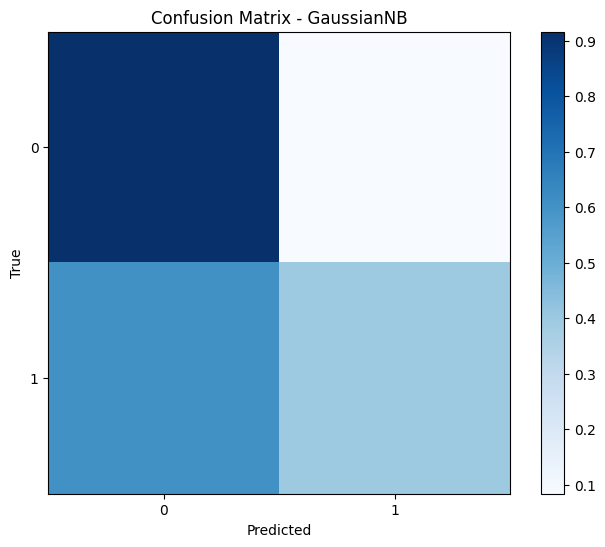

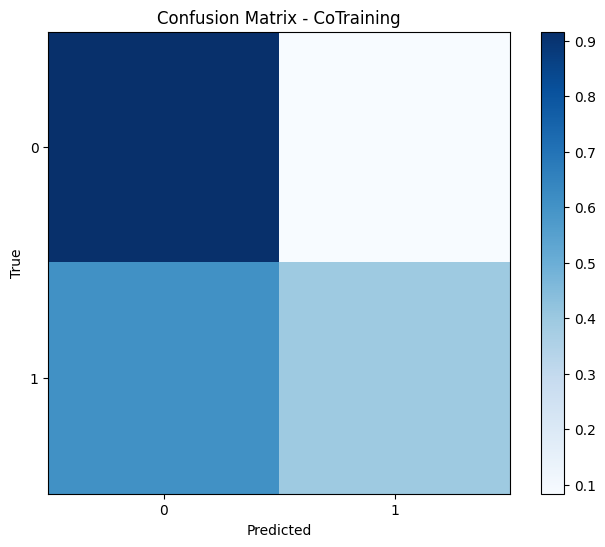

Model Performance Results:
shape: (2, 3)
┌────────────┬──────────┬──────────┐
│ model      ┆ accuracy ┆ f1       │
│ ---        ┆ ---      ┆ ---      │
│ str        ┆ f64      ┆ f64      │
╞════════════╪══════════╪══════════╡
│ GaussianNB ┆ 0.618102 ┆ 0.597689 │
│ CoTraining ┆ 0.617486 ┆ 0.596841 │
└────────────┴──────────┴──────────┘

Best Model:
shape: (1, 2)
┌────────────┬──────────┐
│ model      ┆ accuracy │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ GaussianNB ┆ 0.618102 │
└────────────┴──────────┘


In [3]:
import polars as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


results = pl.DataFrame(
    {
        "model": pl.Series([], dtype=pl.Utf8),
        "accuracy": pl.Series([], dtype=pl.Float64),
        "f1": pl.Series([], dtype=pl.Float64),
    }
)

y = df["Cover_Type"].to_numpy()
X = df.select(pl.all().exclude(["Cover_Type"])).to_numpy()

class_1_mask = y == 1
class_2_mask = y == 2
binary_mask = class_1_mask | class_2_mask

X_binary = X[binary_mask]
y_binary = y[binary_mask]

# Map the classes to 0 and 1 (for binary classification)
y_binary = np.where(y_binary == 1, 0, 1)  # Class 1 -> 0, Class 2 -> 1

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42
)


## Randomly select 5% of training labels to be -1
num_labels = len(y_train)
num_to_modify = int(0.05 * num_labels)
indices_to_modify = np.random.choice(num_labels, num_to_modify, replace=False)
y_train_modified = y_train.copy()
y_train_modified[indices_to_modify] = -1

# Split training data into three sets:
# 1. Samples with both -1 and normal labels
# 2. Samples with only normal labels
mask = y_train_modified != -1

X_train_mixed = X_train
y_train_mixed = y_train_modified

X_train_no_unlabel = X_train[mask]
y_train_no_unlabel = y_train[mask]


# Training and evaluation function
def train_and_evaluate(model: BaseEstimator, model_name: str, is_cotraining=False):
    if is_cotraining:
        model.fit(X_train_mixed, y_train_mixed)
    else:
        model.fit(X_train_no_unlabel, y_train_no_unlabel)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    cm = confusion_matrix(y_test, y_pred, normalize="true")
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.colorbar()
    classes = np.unique(y_test)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return pl.DataFrame(
        {
            "model": [model_name],
            "accuracy": [accuracy],
            "f1": [f1],
        }
    )


models = [
    ("GaussianNB", GaussianNB(), False),
    (
        "CoTraining",
        CoTrainingClassifier(GaussianNB()),
        True,
    ),
]

for model_name, model, is_cotraining in models:
    new_results = train_and_evaluate(model, model_name, is_cotraining)
    results = results.vstack(new_results)

print("Model Performance Results:")
print(results)

best_model = results.filter(pl.col("accuracy") == pl.col("accuracy").max()).select(
    ["model", "accuracy"]
)

print("\nBest Model:")
print(best_model)

## Análisis
- El CoTraining está rindiendo ligeramente peor que el clasificador base GaussianNB tanto en precisión como en puntuación F1, lo cual es inesperado porque el CoTraining debería mejorar el rendimiento utilizando el método de etiquetado en observaciones sin etiquetas.
- El CoTraining asume que tienes dos "vistas" o conjuntos de características que son relativamente independientes pero cada una suficientemente informativa. Si las vistas no son lo suficientemente independientes, los clasificadores podrían estar aprendiendo patrones redundantes.
- Además, el número de iteraciones, cuántos ejemplos etiquetar en cada iteración, y el umbral de confianza para la etiquetación son hiperparámetros críticos que necesitan ser ajustados.
